In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns

from tabulate import tabulate
from scipy.stats import pearsonr, spearmanr, zscore

pd.set_option("display.width", 80)
pd.set_option("display.max_colwidth", None)

In [2]:
# 1. load all data files and pair them as a corpus
data_files = os.listdir("data")
reward_df_files = sorted(
    [f for f in data_files if "scoredreward_humanassistant_includeprompt" in f]
)
nll_df_files = sorted(
    [f for f in data_files if "scorednll" in f and "includeprompt" not in f]
)
paired_files = [(r, n) for r, n in zip(reward_df_files, nll_df_files)]
paired_files

[('ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.0_humanassistant_scoredreward_humanassistant_includeprompt.csv',
  'ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.0_humanassistant_scorednll.csv'),
 ('ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.5_humanassistant_scoredreward_humanassistant_includeprompt.csv',
  'ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.5_humanassistant_scorednll.csv'),
 ('ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t2.0_humanassistant_scoredreward_humanassistant_includeprompt.csv',
  'ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t2.0_humanassistant_scorednll.csv'),
 ('ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_top_p090_t1.0_humanassistant_scoredreward_humanassistant_includep

In [5]:
# 2. set parameters
num_corpuses = 1000
num_samples_per_corpus = 400
colours = [
    "r",
    "b",
    "g",
    "y",
    "m",
    "c",
    "lightcoral",
    "lightblue",
    "lightgreen",
    "lightyellow",
    "lightpink",
    "lightcyan",
    "gray",
]
names = [
    "anc_t1.0",
    "anc_t1.5",
    "anc_t2.0",
    "p090_t1.0",
    "p090_t1.5",
    "p090_t2.0",
    "p095_t1.0",
    "p095_t1.5",
    "p095_t2.0",
]



Analyzing ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.0_humanassistant_scoredreward_humanassistant_includeprompt.csv and ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.0_humanassistant_scorednll.csv:
Length: 1928
+----+------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

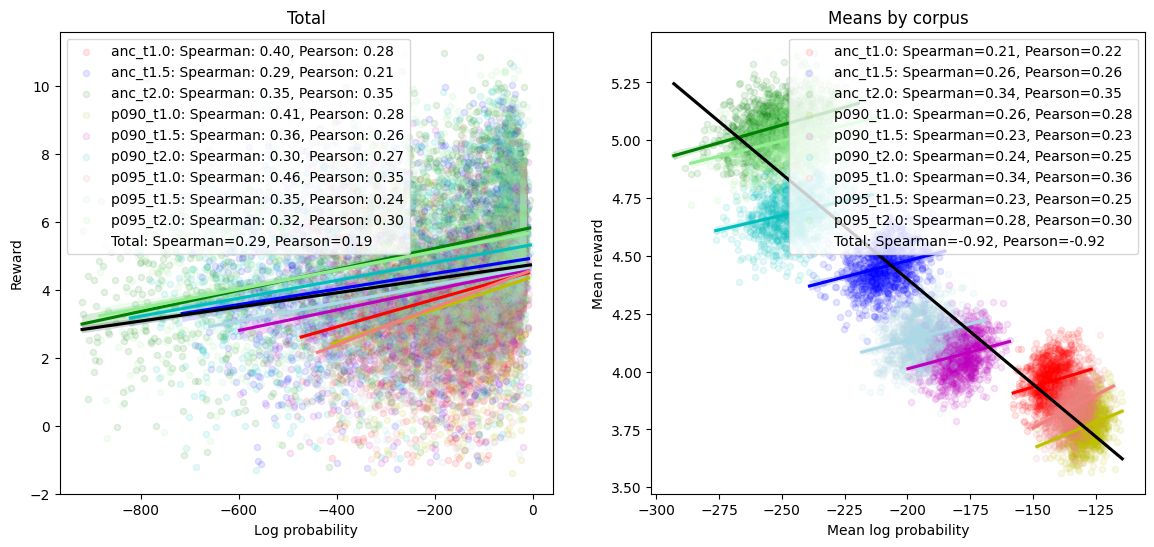

In [6]:
# 3. analysis on each corpus
# 3.0 a single output figure
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
total_mean_corpuses = None
total_corpus = None
for idx, (reward_df_file, nll_df_file) in enumerate(paired_files):
    print(f"\n\nAnalyzing {reward_df_file} and {nll_df_file}:")
    # 3.1 load and merge
    reward_df = pd.read_csv(f"data/{reward_df_file}")
    nll_df = pd.read_csv(f"data/{nll_df_file}")
    df = reward_df.merge(nll_df, on=["prompt", "generated_text"])
    df["log_probability"] = -df["negative_log_probability"]
    df = df[
        df.apply(lambda row: len(row["generated_text"]) > 0, axis=1)
    ].drop_duplicates()
    df = df[(np.abs(zscore(df[["score", "log_probability"]])) < 3).all(axis=1)]

    print(f"Length: {len(df)}")
    print(tabulate(df.head(), headers="keys", tablefmt="psql"))
    print(
        tabulate(
            df[["score", "log_probability"]].describe(), headers="keys", tablefmt="psql"
        )
    )

    # 3.2 Sample level
    print("===== Sample level statistics =====")
    # 3.2.1 Scatter
    spearman = spearmanr(df["score"], df["log_probability"])
    pearson = pearsonr(df["score"], df["log_probability"])
    print(f"Spearman: {spearman}")
    print(f"Pearson: {pearson}")
    df.plot.scatter(
        y="score",
        x="log_probability",
        title="Samples",
        ax=axs[0],
        c=colours[idx],
        alpha=0.1,
        label=f"{names[idx]}: Spearman: {spearman[0]:.2f}, Pearson: {pearson[0]:.2f}",
    )
    # 3.2.2 best fit line
    sns.regplot(
        y="score",
        x="log_probability",
        data=df,
        ax=axs[0],
        scatter=False,
        color=colours[idx],
    )
    if total_corpus is None:
        total_corpus = df
    else:
        total_corpus = pd.concat([total_corpus, df])

    # 3.3 Corpus level
    print("===== Corpus level statistics =====")
    # 3.3.1 Sample corpuses
    corpuses = {
        corpus_seed: df.sample(
            num_samples_per_corpus, random_state=corpus_seed, replace=True
        )
        for corpus_seed in range(num_corpuses)
    }
    mean_corpuses_df = pd.DataFrame.from_dict({
        corpus_seed: corpus[["score", "log_probability"]].mean(axis=0)
        for corpus_seed, corpus in corpuses.items()
    }).T
    spearman = spearmanr(mean_corpuses_df["score"], mean_corpuses_df["log_probability"])
    pearson = pearsonr(mean_corpuses_df["score"], mean_corpuses_df["log_probability"])
    print(f"Spearman: {spearman}")
    print(f"Pearson: {pearson}")
    mean_corpuses_df.plot.scatter(
        y="score",
        x="log_probability",
        title="Means by corpus",
        ax=axs[1],
        c=colours[idx],
        alpha=0.1,
        label=f"{names[idx]}: Spearman={spearman[0]:.2f}, Pearson={pearson[0]:.2f}",
    )
    if total_mean_corpuses is None:
        total_mean_corpuses = mean_corpuses_df
    else:
        total_mean_corpuses = pd.concat([total_mean_corpuses, mean_corpuses_df])

    # 3.3.2 best fit line
    sns.regplot(
        y="score",
        x="log_probability",
        data=mean_corpuses_df,
        ax=axs[1],
        scatter=False,
        color=colours[idx],
    )


# 4. Total corpus level statistics
print("===== Total corpus level statistics =====")
spearman = spearmanr(total_corpus["score"], total_corpus["log_probability"])
pearson = pearsonr(total_corpus["score"], total_corpus["log_probability"])
print(f"Spearman: {spearman}")
print(f"Pearson: {pearson}")
total_corpus.plot.scatter(
    y="score",
    x="log_probability",
    title="Total",
    alpha=0.0,
    label=f"Total: Spearman={spearman[0]:.2f}, Pearson={pearson[0]:.2f}",
    ax=axs[0],
)
sns.regplot(
    y="score",
    x="log_probability",
    data=total_corpus,
    scatter=False,
    color="black",
    ax=axs[0],
)
axs[0].set_ylabel("Reward")
axs[0].set_xlabel("Log probability")


print("===== Total corpus mean statistics =====")
spearman = spearmanr(
    total_mean_corpuses["score"], total_mean_corpuses["log_probability"]
)
pearson = pearsonr(total_mean_corpuses["score"], total_mean_corpuses["log_probability"])
print(f"Spearman: {spearman}")
print(f"Pearson: {pearson}")
total_mean_corpuses.plot.scatter(
    y="score",
    x="log_probability",
    title="Means by corpus",
    alpha=0.0,
    label=f"Total: Spearman={spearman[0]:.2f}, Pearson={pearson[0]:.2f}",
    ax=axs[1],
    ylabel="Mean score",
    xlabel="Mean log probability",
)

sns.regplot(
    y="score",
    x="log_probability",
    data=total_mean_corpuses,
    scatter=False,
    color="black",
    ax=axs[1],
)
axs[1].set_ylabel("Mean reward")
axs[1].set_xlabel("Mean log probability")

plt.legend()
plt.show()
plt.close()